In [14]:
# Import packages
import mne, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mne.io import RawArray
from mne.time_frequency import psd_array_welch
from mne.decoding import SSD
from basic.arrange_data import read_files

# Set default directory
os.chdir('/Users/tanijarv/Documents/GitHub/EEG-pyline')
mne.set_log_level('error')

# Folder where to get the raw EEG files
raw_folder = 'Data/Raw/'

# Sub-folder for the experiment (i.e. timepoint or group)
exp_folder = 'LEISURE/Eyes Closed/T1-one_sample'

# EOG + mastoid channels and stimulus channel
eog_channels = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8']
stimulus_channel = 'Status'

# Get directories of raw EEG files and set export directory for clean files
dir_inprogress = os.path.join(raw_folder,exp_folder)
file_dirs, subject_names = read_files(dir_inprogress,'.bdf')

# Get the first file
raw = mne.io.read_raw_bdf(file_dirs[0], infer_types=True, eog=eog_channels,
                          stim_channel=stimulus_channel)

# Set the right montage (Biosemi32) and set reference as average across all channels
raw = raw.set_montage(mne.channels.make_standard_montage('biosemi32')).load_data()\
            .set_eeg_reference(ref_channels='average')

# Find stimulus points, i.e. start and end of resting state, and crop the signal
events = mne.find_events(raw, stim_channel=stimulus_channel, consecutive=False, output='offset')
cropped_raw = raw.crop(tmin=events[0][0]/raw.info['sfreq'], tmax=events[-1][0]/raw.info['sfreq'])

# Pick only EEG channels
raw = cropped_raw.copy().pick_types(eeg=True)

Files in Data/Raw/LEISURE/Eyes Closed/T1-one_sample read in: 1


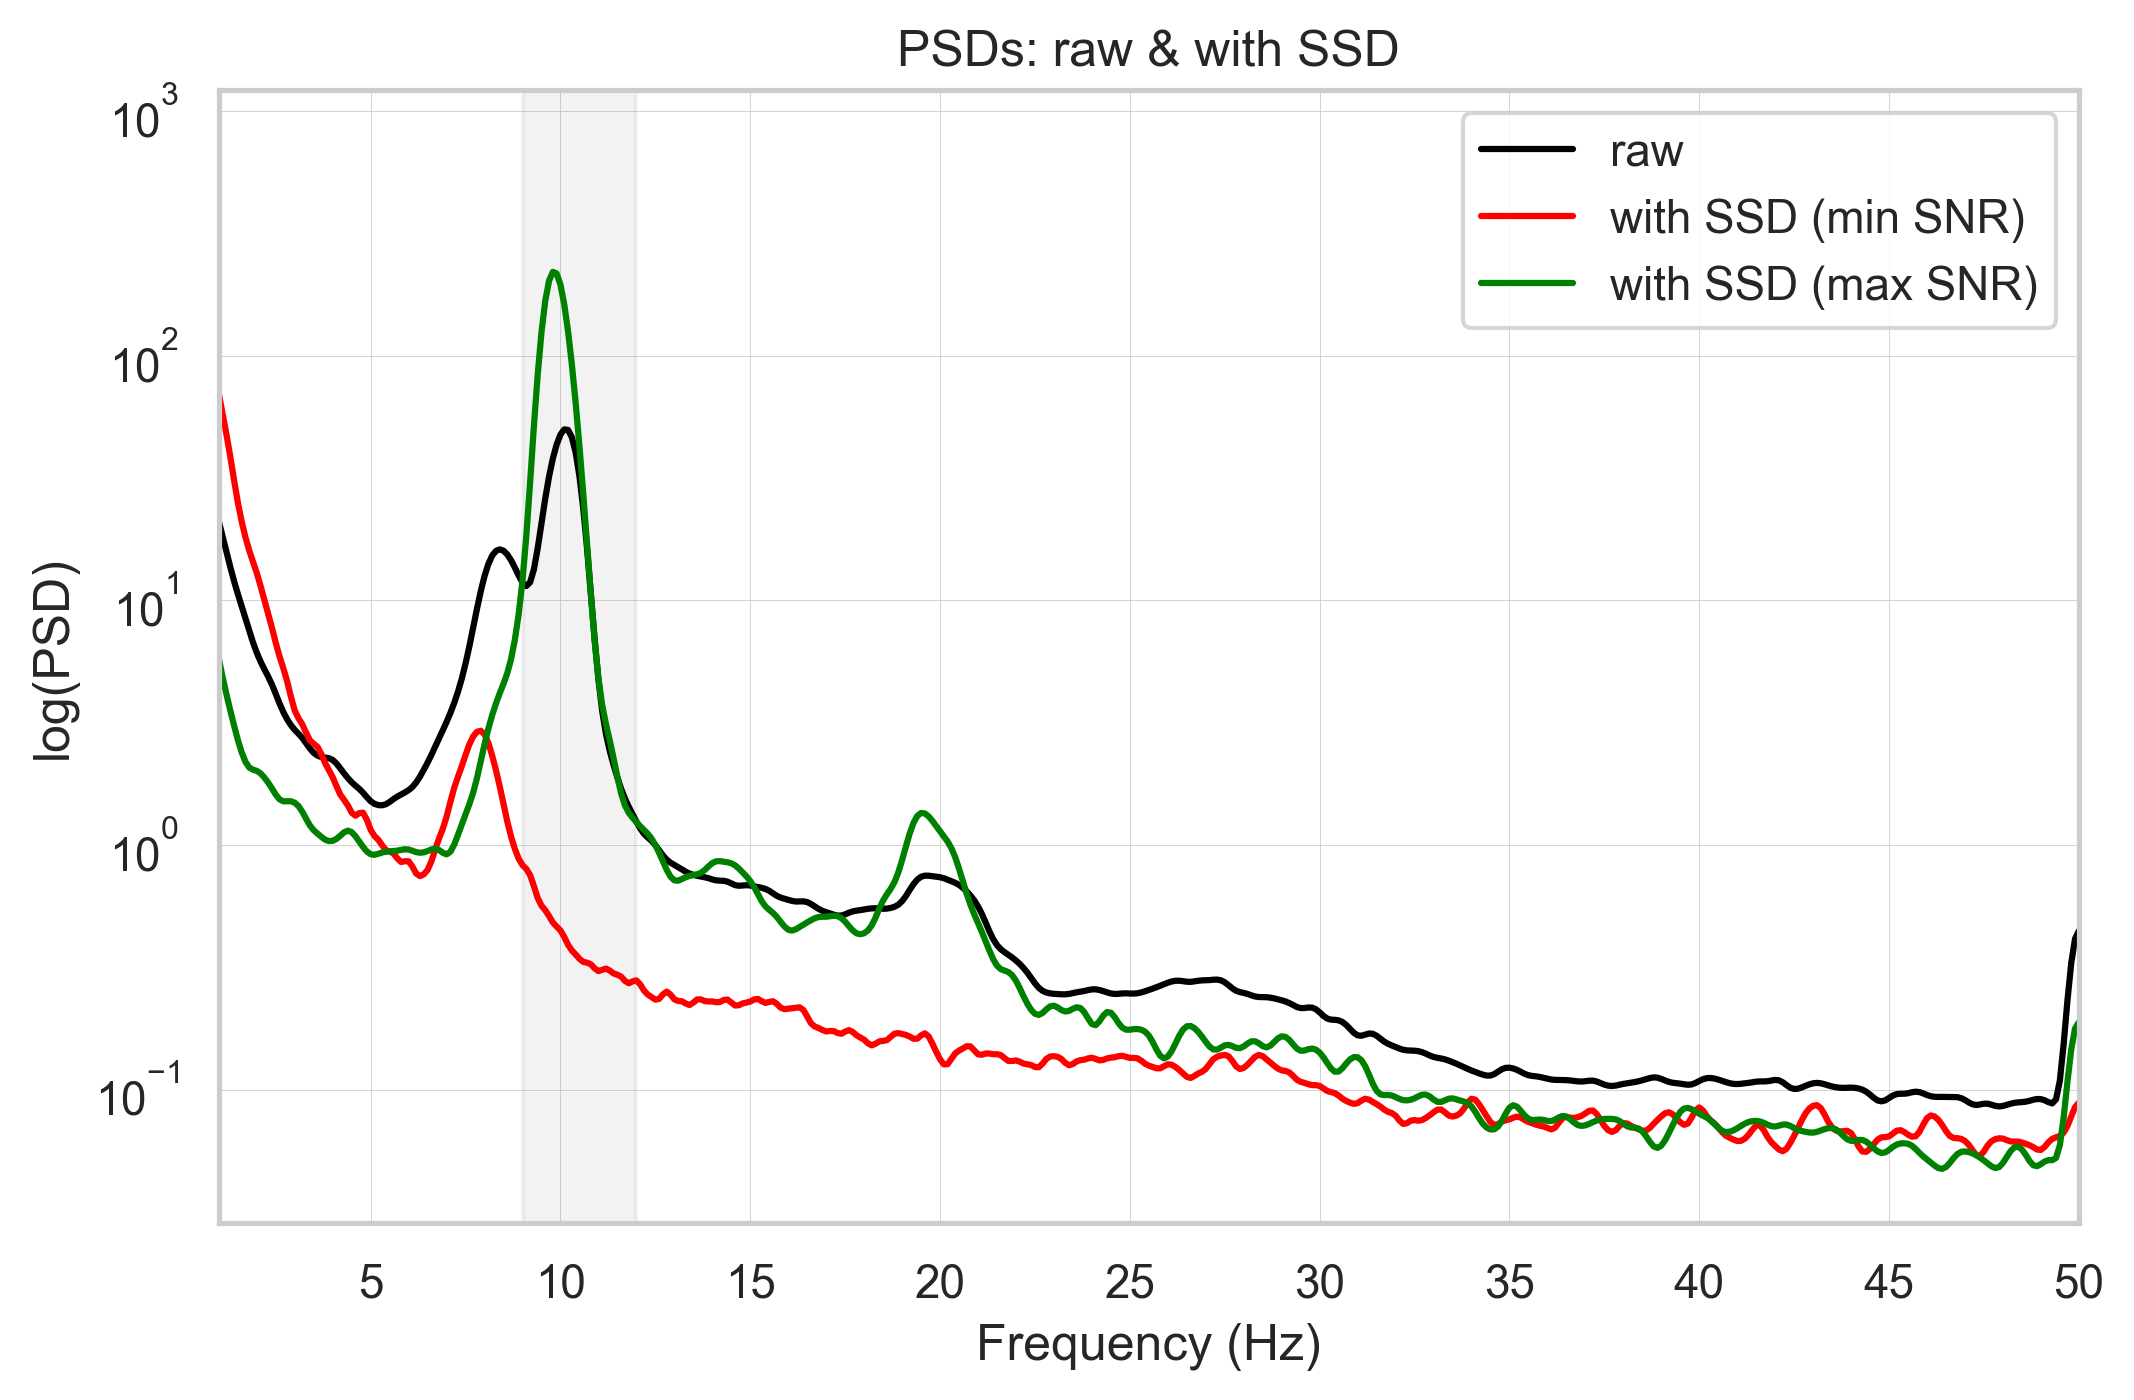

In [22]:
# Calculate window size in samples and window size x coefs for overlap and zero-pad
fminmax = [1, 50]
window_size = int(raw.info['sfreq']*2.5)
n_overlap = int(window_size*0.5)
n_zeropad = int(window_size*3)

# Set the PSD estimation parameters
psd_params = dict(fmin=fminmax[0], fmax=fminmax[1],
                  window='hamming',
                  n_per_seg=window_size,
                  n_fft=window_size+n_zeropad,
                  n_overlap=n_overlap)

# Set the signal and noise frequency ranges for SSD
signal_freqs = [9, 12]
noise_freqs = [8, 13]

# Calculate and plot PSD before applying SSD
psd_before, freqs = psd_array_welch(raw.get_data(), raw.info['sfreq'], **psd_params)
psd_before = psd_before*1e12

# Apply SSD on the PSD
ssd = SSD(info=raw.info,
          filt_params_signal=dict(l_freq=signal_freqs[0], h_freq=signal_freqs[1]),
          filt_params_noise=dict(l_freq=noise_freqs[0], h_freq=noise_freqs[1]))
ssd.fit(X=raw.get_data())

# Transform the raw data using SSD spatial filters
raw_ssd = ssd.transform(X=raw.get_data())
raw_ssd = RawArray(raw_ssd, raw.info)

# Calculate and plot PSD after applying SSD
psd_after, freqs = psd_array_welch(raw_ssd.get_data(), raw_ssd.info['sfreq'], **psd_params)

# Create a figure
sns.set_style('whitegrid')
sns.set_context('notebook')
plt.figure(figsize=(8,5), dpi=300)

# Plot raw PSD in black, and SSDs in red (min SNR) and green (max SNR)
plt.semilogy(freqs, psd_before.mean(axis=0), label='raw', color='black')
plt.semilogy(freqs, psd_after[-1], label='with SSD (min SNR)', color='red')
plt.semilogy(freqs, psd_after[0], label='with SSD (max SNR)', color='green')

# Fill the area which was defined as 'signal' in SSD calculation
bandpass = (signal_freqs[0] <= freqs) & (freqs <= signal_freqs[1])
plt.fill_between(freqs[bandpass], 0, np.max(psd_after)+10e2, color='gray', alpha=0.1)

# Setting for the plot
plt.xticks(np.arange(min(freqs)-1, max(freqs)+1, 5))
plt.xlabel('Frequency (Hz)')
plt.ylabel('log(PSD)')
plt.xlim(fminmax)
plt.ylim([None, np.max(psd_after)+10e2])
plt.grid(linewidth=0.2)
plt.legend()
plt.title('PSDs: raw & with SSD')
plt.show()